# This Notebook creates some plots and analyses my_databse

**Channel 1-4**: "old cable", broke in middle

**Channel 5-8**: EGRT cable, installed for an EGRT. Could not installed to the bottom of shaft. Some cable lays at surface.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle


############To DO#######################
# Position Spleiß Kasten markieren
#   Ist großer peak in mitte von splice kasten bei channel 7 8? 
#   Denke Ja
#   dort dann auch nach Wassertank gucken, welcher peak es ist
# 
# Plot differences at watertank position over time of corrected data
#
# Create variable plot of # Color Plot for EGRT cable
#   date and channels can be choosed variable
# 
# Make similar Plots to compare all different data sources ###########NEXT STEP######################
#   EGRT
#   Natural State mit Logger in Bohrloch
#   alte Kabel (chan 1-4)
#   Ausbauskizze dabei tun
#
# restructure my current notebooks, to divide import and analysis plots
#
# für abkühlung des wassertanks eiswürfel kaufen 10 kg oder so und in tank rein. Am besten irgendwie an Boden in Box fixieren, damit es irgendwie gleichmäßig abkühlt und nicht eiswürfel direkt am kabel liegen

In [2]:
%%time
# Wall time: 1min 56s

def import_my_database_csv(year,path_to_my_database):
    """ import the data of my_databse, every year seperate"""

    def importer(data_20xx, path_to_my_database, year, c):
        """just for shortening the code"""
        
        filename = f"temp_ch{c}_{year}.csv"
        path_to_file[filename] = path_to_my_database + "\\" + filename

        data_20xx[str(c)] = pd.read_csv(path_to_file[f"temp_ch{c}_{year}.csv"], index_col=0)
        data_20xx[str(c)].index = pd.to_datetime(data_20xx[str(c)].index, infer_datetime_format=True)

        return data_20xx

    path_to_file={}
    data_20xx = {}
    if year == 2021: # all channels are activated since 01.06.2021
        channels = [1,2,3,4,5,6,7,8]
        for c in channels:
            importer(data_20xx, path_to_my_database, year, c)

    if year == 2019 or 2020: # channels 5-8 are empty
        channels = [1,2,3,4]
        for c in channels:
            importer(data_20xx, path_to_my_database, year, c)

    return data_20xx

# # Load csv data
path_to_my_database = r"..\Alsdorf\Daten\my_database"
# data_2019 = import_my_database_csv(2019, path_to_my_database)
# data_2020 = import_my_database_csv(2020, path_to_my_database)
# data_2021 = import_my_database_csv(2021, path_to_my_database)

Wall time: 0 ns


In [3]:
%%time
# Wall time: 7.64 s

def import_my_database_pickle(year, path_to_my_database_pickle):
    """"""
    def read_pickle(filename:str):
        #Function to read pickle Files
        with open(filename, 'rb') as f:
            return pickle.load(f)

    def importer_pickle(data_20xx, path_to_my_database_pickle, year, c):
        """just for shortening the code"""
        
        filename = f"temp_ch{c}_{year}"
        path_to_file[filename] = path_to_my_database_pickle + "\\" + filename

        data_20xx[str(c)] = read_pickle(path_to_file[f"temp_ch{c}_{year}"])
        #data_20xx[str(c)].index = pd.to_datetime(data_20xx[str(c)].index, infer_datetime_format=True)

        return data_20xx

    path_to_file={}
    data_20xx = {}
    if year == 2021: # all channels are activated since 01.06.2021
        channels = [1,2,3,4,5,6,7,8]
        for c in channels:
            importer_pickle(data_20xx, path_to_my_database_pickle, year, c)

    if year == 2019 or 2020: # channels 5-8 are empty
        channels = [1,2,3,4]
        for c in channels:
            importer_pickle(data_20xx, path_to_my_database_pickle, year, c)

    return data_20xx


# Load pickle Data
path_to_my_database_pickle = path_to_my_database + r"\pickle"
data_2021=import_my_database_pickle(2021, path_to_my_database_pickle)
data_2020=import_my_database_pickle(2020, path_to_my_database_pickle)
data_2019=import_my_database_pickle(2019, path_to_my_database_pickle)

Wall time: 7.64 s


In [4]:
%%time
#Wall time: 19.7 s
# Merge the different year dics into one
def merge_data_year(list_data_years):
    """input the different year dics as a list"""
    data = {}

    for data_20xx in list_data_years:
        for channel in data_20xx.keys():

            if channel in data.keys():
                data[channel] = pd.concat([data[channel], data_20xx[channel]], axis = 0)

            else: # channel not in data dic
                data[channel] = data_20xx[channel]

    #eventle noch sort index machen !!!!!!!!!!F!!!!!!!!!!!!!!!
    return data

data_all = merge_data_year([data_2019, data_2020, data_2021])

Wall time: 27.8 s


In [5]:
# Load data T-logger
path_to_data_Tlogger = r"..\Alsdorf\Daten\T-logger"
filename_Tlogger = "08062021\_adc_START_07.06.2021-12_11_40_daten.txt"

df_Tlogger = pd.read_csv(path_to_data_Tlogger + "\\" + filename_Tlogger, sep=";", usecols=[1,2,3,4], names=["Date","Time","Channel1-Watertank","Channel2-Air"])
DateTime=df_Tlogger["Date"] + " " + df_Tlogger["Time"]
df_Tlogger.index =pd.to_datetime(DateTime, format=("%d.%m.%y  %H:%M:%S"))
df_Tlogger.index.names = ['Date']
df_Tlogger = df_Tlogger.drop(df_Tlogger.columns[0:2],axis=1) # drop the two columns which are now used for index

# Drop data from T- Logger when I was there, because measurent stopps can be a bit tricky to handly in this script
index_for_drop=df_Tlogger.index[:400]
index_for_drop2=df_Tlogger.index[-300:]
df_Tlogger=df_Tlogger.drop(index_for_drop)
df_Tlogger=df_Tlogger.drop(index_for_drop2)
df_Tlogger

Channel1-Watertank  Channel2-Air
Date                                                 
2021-06-07 18:52:45           25.202959     24.067373
2021-06-07 18:53:45           25.149417     24.067373
2021-06-07 18:54:45           25.155868     24.060148
2021-06-07 18:55:45           25.190380     24.067632
2021-06-07 18:56:45           25.124259     24.071243
...                                 ...           ...
2021-06-08 08:13:53           25.322296     24.401262
2021-06-08 08:14:53           25.344228     24.407197
2021-06-08 08:15:53           25.319070     24.409778
2021-06-08 08:16:53           25.271980     24.414937
2021-06-08 08:17:53           25.297138     24.433258

[806 rows x 2 columns]

C:\Users\Mathis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


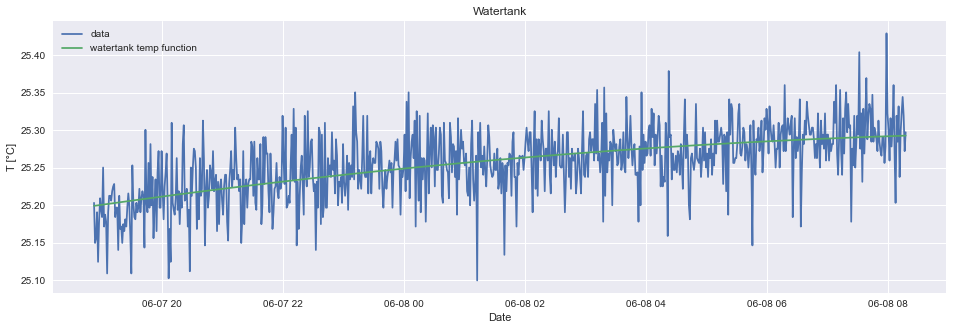

In [6]:
# Fit function to watertank temperatures - Polynomial
# I think thats not optimal yet #############################################################
# thats not optimal, maybe I should ask norbert for a better way of averaging the data to contineous function
x=mdates.date2num(df_Tlogger["Channel1-Watertank"].index)
y=df_Tlogger["Channel1-Watertank"].values
watertank_T_range_min = df_Tlogger["Channel1-Watertank"].index.min()
watertank_T_range_max = df_Tlogger["Channel1-Watertank"].index.max()

deg=3
fit_watertank_func=np.polyfit(x,y,deg=deg)
def temp_watertank_func(x,fit_watertank_func):
    """Function to interpolate between the T-Logger T values
    Having a continous Temperature of the watertank makes calculation easier

    How to use this function:
    temp_watertank_func(x,fit_watertank_func)
    x has to be mdates.date2num(date value I want watertank temp for)
    """
    result=0
    for i in range(deg+1):
        exp=deg-i
        result+=fit_watertank_func[i]*x**(exp) #i=0 has highest power
    return result

# Plot function and data, to see if it is good
x_dates=mdates.num2date(x)
T_avearage=temp_watertank_func(x,fit_watertank_func) 
plt.style.use("seaborn")
plt.figure(figsize=(16,5))
plt.plot(x_dates,y,label="data")
plt.plot(x_dates,T_avearage,label="watertank temp function")
plt.ylabel("T [°C]")
plt.xlabel("Date")
plt.title("Watertank")
plt.legend()
plt.show()
#Wassertank am 07.06.2021 aufgefüllt, mit kälteren Wasser

In [7]:
# # Fit function to watertank temperatures - Periodic - not good
# x=mdates.date2num(df_Tlogger["Channel1-Watertank"].index)
# y=df_Tlogger["Channel1-Watertank"].values

# def test_func(x, a, b):
#     return a * np.sin(b * x)

# params, params_covariance = optimize.curve_fit(test_func, x, y,p0=[2, 2])

# plt.figure(figsize=(6, 4))
# plt.scatter(x, y, label='Data')
# plt.plot(x, test_func(x, params[0], params[1]),
#          label='Fitted function')

# plt.legend(loc='best')

# plt.show()

In [8]:
# Plot Helper
def color_cable_pos(start_len, end_len, col, ymax, ymin):
    """ creates patches which color the plot"""
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax+ymin,color=col,alpha=0.2)
    axs.add_patch(Rectangle)

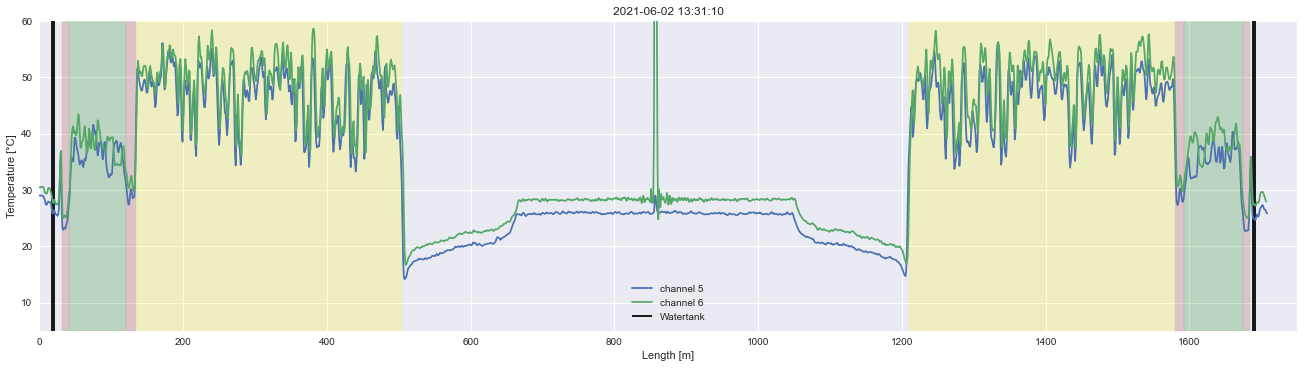

In [9]:
# Color Plot for EGRT cable
from ipywidgets import interactive

########################INPUT#########################################
channel=["5","6"]
#channel=["7","8"]
date=-265 #from last measurements; compare -20 and -265 for determine of colors; range 0 bis 310
display_from=0
display_to=1750 # max 3500 for channel 7,8; max 1750 for channel 5,6
#######################################################################

corrected_val={}
fig,axs=plt.subplots(1,1,figsize=[18,5],constrained_layout=True)
#plt.vline
for chan in channel:
    length=data_all[chan].iloc[date].index[display_from:display_to]
    x=np.array(length).astype(int)#[:int(int(length[-1])/2)] #use this if plot half the cable; channel 7,8 - Was bedeutet das?
    corrected_val[chan]=np.array(data_all[chan].iloc[date].values)[display_from:display_to] #- diff_in_watertank[chan]
    date_name=data_all[chan].iloc[date].name

    y=corrected_val[chan]#[:int(int(length[-1])/2)] #use this if plot half the cable; channel 7,8
    axs.plot(x,y,label=f"channel {chan}")
    axs.set_title(data_all[chan].iloc[date].name)
ymax=60
ymin=5
axs.set_ylim(ymin,ymax)
axs.set_xlim(display_from,display_to)
axs.set_xlabel("Length [m]")
axs.set_ylabel("Temperature [°C]")


splice_pos=1707 # splice position of long cable, not exactly at middle due to pig tail
#plt.vlines(splice_pos,5,40, color="black",label="splice position?")
#plt.vlines([splice_pos+10,splice_pos-10,splice_pos+17,splice_pos-17],5,40,label="watertank position?")
#plt.vlines([splice_pos+14,splice_pos-14],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")
#plt.vlines([1580,1595],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")


# # Positions Cable buried - txt field
# size=11; y=25; ha="center"; va="center"
# bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
# x=36
# if display_from < x and display_to > x:
#     y=data_all[chan].iloc[date][x] - 8
#     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)
# x=130
# if display_from < x and display_to > x:
#     y=data_all[chan].iloc[date][x] - 8
#     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)

#axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label="Approx. start of Alsdorf Data", colors="black",linestyles="-")

# Cable Buried; two positions are buried: 1, 2
color_cable_pos(31,41,"brown",ymax,ymin) #1
color_cable_pos(121,134,"brown",ymax,ymin)#2
color_cable_pos(1580,1593,"brown",ymax,ymin)#2
color_cable_pos(1674,1684,"brown",ymax,ymin)#1
if channel == ["7","8"] or channel == ["5","6","7","8"] or channel == ["7"] or channel == ["8"]:
    color_cable_pos(1732,1742,"brown",ymax,ymin)#1
    color_cable_pos(1820,1833,"brown",ymax,ymin)#1
    color_cable_pos(3280,3293,"brown",ymax,ymin)#2
    color_cable_pos(3374,3384,"brown",ymax,ymin)#1

#Position cable Fence
color_cable_pos(1593,1674,"green",ymax,ymin)
color_cable_pos(41,121,"green",ymax,ymin)
if channel == ["7","8"] or channel == ["5","6","7","8"] or channel == ["7"] or channel == ["8"]:
    color_cable_pos(1742,1820,"green",ymax,ymin)
    color_cable_pos(3293,3374,"green",ymax,ymin)

#Position cable at surface 
color_cable_pos(134,504,"yellow",ymax,ymin)
color_cable_pos(1210,1580,"yellow",ymax,ymin)
if channel == ["7","8"] or channel == ["5","6","7","8"] or channel == ["7"] or channel == ["8"]:
    color_cable_pos(1833,2203,"yellow",ymax,ymin)
    color_cable_pos(2910,3280,"yellow",ymax,ymin)

#Position cable Watertank -------------unsure-----------should change Temp of watertank to be sure
color_cable_pos(18,20,"blue",ymax,ymin)
axs.vlines(18,ymin,ymax, color="black", label="Watertank")
axs.vlines(20,ymin,ymax, color="black")
#data_all["5"].columns[-20] # --> 1689; -20 because last value corresponds to 0
color_cable_pos(1689,1691,"blue",ymax,ymin)
axs.vlines(1689,ymin,ymax, color="black")
axs.vlines(1691,ymin,ymax, color="black")
if channel == ["7","8"] or channel == ["5","6","7","8"] or channel == ["7"] or channel == ["8"]:
    color_cable_pos(1722,1724,"blue",ymax,ymin)
    axs.vlines(1722,ymin,ymax, color="black")
    axs.vlines(1724,ymin,ymax, color="black")
    color_cable_pos(3388,3390,"blue",ymax,ymin)
    axs.vlines(3388,ymin,ymax, color="black")
    axs.vlines(3390,ymin,ymax, color="black")

axs.legend()
plt.show()

############Werte noch mit Notizen von Kabellänge überprüfen!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# In sich sind die Werte nicht ganz stimmig!

In [10]:
def interactive_plot_function(channel,date,display_from,display_to):
    # I need to define this function in here, so it can be used in interactive. Copied it from above (non-interactive plot)
    def color_cable_pos(start_len, end_len, col, ymax, ymin):
        """ creates patches which color the plot"""
        width = end_len - start_len
        Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax+ymin,color=col,alpha=0.2)
        axs.add_patch(Rectangle)


    corrected_val={}
    fig,axs=plt.subplots(1,1,figsize=[18,5],constrained_layout=True)
    #plt.vline
    for chan in channel:
        length=data_all[chan].iloc[date].index[display_from:display_to]
        x=np.array(length).astype(int)#[:int(int(length[-1])/2)] #use this if plot half the cable; channel 7,8 - Was bedeutet das?
        corrected_val[chan]=np.array(data_all[chan].iloc[date].values)[display_from:display_to] #- diff_in_watertank[chan]
        date_name=data_all[chan].iloc[date].name

        y=corrected_val[chan]#[:int(int(length[-1])/2)] #use this if plot half the cable; channel 7,8
        axs.plot(x,y,label=f"channel {chan}")
        axs.set_title(data_all[chan].iloc[date].name)
    ymax=60
    ymin=5
    axs.set_ylim(ymin,ymax)
    axs.set_xlim(display_from,display_to)
    axs.set_xlabel("Length [m]")
    axs.set_ylabel("Temperature [°C]")


    splice_pos=1707 # splice position of long cable, not exactly at middle due to pig tail
    #plt.vlines(splice_pos,5,40, color="black",label="splice position?")
    #plt.vlines([splice_pos+10,splice_pos-10,splice_pos+17,splice_pos-17],5,40,label="watertank position?")
    #plt.vlines([splice_pos+14,splice_pos-14],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")
    #plt.vlines([1580,1595],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")


    # # Positions Cable buried - txt field
    # size=11; y=25; ha="center"; va="center"
    # bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    # x=36
    # if display_from < x and display_to > x:
    #     y=data_all[chan].iloc[date][x] - 8
    #     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)
    # x=130
    # if display_from < x and display_to > x:
    #     y=data_all[chan].iloc[date][x] - 8
    #     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)

    #axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label="Approx. start of Alsdorf Data", colors="black",linestyles="-")

    # Cable Buried; two positions are buried: 1, 2
    color_cable_pos(31,41,"brown",ymax,ymin) #1
    color_cable_pos(121,134,"brown",ymax,ymin)#2
    color_cable_pos(1580,1593,"brown",ymax,ymin)#2
    color_cable_pos(1674,1684,"brown",ymax,ymin)#1
    if channel == ["7","8"] or channel == ["5","6","7","8"] or channel == ["7"] or channel == ["8"]:
        color_cable_pos(1732,1742,"brown",ymax,ymin)#1
        color_cable_pos(1820,1833,"brown",ymax,ymin)#1
        color_cable_pos(3280,3293,"brown",ymax,ymin)#2
        color_cable_pos(3374,3384,"brown",ymax,ymin)#1

    #Position cable Fence
    color_cable_pos(1593,1674,"green",ymax,ymin)
    color_cable_pos(41,121,"green",ymax,ymin)
    if channel == ["7","8"] or channel == ["5","6","7","8"] or channel == ["7"] or channel == ["8"]:
        color_cable_pos(1742,1820,"green",ymax,ymin)
        color_cable_pos(3293,3374,"green",ymax,ymin)

    #Position cable at surface 
    color_cable_pos(134,504,"yellow",ymax,ymin)
    color_cable_pos(1210,1580,"yellow",ymax,ymin)
    if channel == ["7","8"] or channel == ["5","6","7","8"] or channel == ["7"] or channel == ["8"]:
        color_cable_pos(1833,2203,"yellow",ymax,ymin)
        color_cable_pos(2910,3280,"yellow",ymax,ymin)

    #Position cable Watertank -------------unsure-----------should change Temp of watertank to be sure
    color_cable_pos(18,20,"blue",ymax,ymin)
    axs.vlines(18,ymin,ymax, color="black", label="Watertank")
    axs.vlines(20,ymin,ymax, color="black")
    #data_all["5"].columns[-20] # --> 1689; -20 because last value corresponds to 0
    color_cable_pos(1689,1691,"blue",ymax,ymin)
    axs.vlines(1689,ymin,ymax, color="black")
    axs.vlines(1691,ymin,ymax, color="black")
    if channel == ["7","8"] or channel == ["5","6","7","8"] or channel == ["7"] or channel == ["8"]:
        color_cable_pos(1722,1724,"blue",ymax,ymin)
        axs.vlines(1722,ymin,ymax, color="black")
        axs.vlines(1724,ymin,ymax, color="black")
        color_cable_pos(3388,3390,"blue",ymax,ymin)
        axs.vlines(3388,ymin,ymax, color="black")
        axs.vlines(3390,ymin,ymax, color="black")

    axs.legend()
    plt.show()

In [11]:
# Color Plot for EGRT cable - Interactive
# maybe this libary is better:
# I think this includes some hovering information 
#https://plotly.com/python/creating-and-updating-figures/ # mpsste da mal ein basic tutoial zu machen
#implementing hovering in matplotlib is rather difficult
#https://stackoverflow.com/questions/7908636/is-it-possible-to-make-labels-appear-when-hovering-mouse-over-a-point-in-matplot
#I use this libary:
#https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#interactive
from ipywidgets import interact
import ipywidgets as widgets

########################INPUT#########################################
channel=["5","6"]
#channel=["7","8"]
date=-265 #from last measurements; compare -20 and -265 for determine of colors; range 0 bis 310
display_from=0
display_to=1750 # max 3500 for channel 7,8; max 1750 for channel 5,6
#######################################################################

interact(interactive_plot_function,
channel=[["5","6"],["7","8"],["5","6","7","8"],"5","6","7","8"], 
date=widgets.IntSlider(min=0, max=310, step=1, value=280), 
display_from=widgets.IntSlider(min=0, max=3350, step=10, value=0), 
display_to=widgets.IntSlider(min=10, max=3400, step=10, value=1750))

interactive(children=(Dropdown(description='channel', options=(['5', '6'], ['7', '8'], ['5', '6', '7', '8'], '…

<function __main__.interactive_plot_function(channel, date, display_from, display_to)>

# Compare EGRT Cable Measurements to Watertank

In [12]:
def find_nearest_date(base_date_name,date_index):
    """find the nearest date to base_date_name in date_index
    base_date_name: put in as str or Timestamp, I use a format like this: '2021-06-07 18:52:45'
    date_index: index of a dataframe, which contains dates
    returns:
    date_name: str
    date_iloc: position of date_name in date_index
    """
    date_iloc=date_index.get_loc(base_date_name,method="nearest")
    date_name=str(date_index[date_iloc])
    return date_name, date_iloc

In [13]:
# Correction for waterteank temp difference
watertank_len=[19,1690,1723,3389] # position DTS cable, where it is in watertank
val_watertank_ch={}
diff_in_watertank={}
corrected_val=defaultdict(dict)
diff_watertank_aftercorr_alldates={}
for chan in ["5","6","7","8"]:
    # find the date range of this channel, which also is covered by the T-Logger
    date_name_min, date_iloc_min = find_nearest_date(watertank_T_range_min,data_all[chan].index)
    date_name_max, date_iloc_max = find_nearest_date(watertank_T_range_max,data_all[chan].index)
    all_dates_in_range_channel   = data_all[chan].index[date_iloc_min:date_iloc_max]
    for date_name in all_dates_in_range_channel:
        # Using chan in the following is somewhat unnecessary, because one date belongs only to one channel
        # But Its not that bad I would say, because it makes things more explicit
        date_numeric=mdates.date2num(date_name) # crate numeric of date for calculations
        # T of DTS cable at first watertank position
        val_watertank_ch[chan]=data_all[chan].loc[str(date_name)][watertank_len[0]]
        val_watertank=temp_watertank_func(date_numeric,fit_watertank_func) # T of watertank, measured by PT100
        # difference between PT100 and DTS at first watertank position
        diff_in_watertank[chan]=val_watertank_ch[chan] - val_watertank
        # correct watertank diff; for all DTS points, based on first watertank position
        chan_val = np.array(data_all[chan].loc[str(date_name)].values)
        corrected_val[date_name][chan] = chan_val - diff_in_watertank[chan]

        # Create dataframe to save diffs at all watertank positions after correction
        diff_watertank_aftercorr = pd.DataFrame(columns=[chan], index=[19,1690,1723, 3389])
        diff_watertank_aftercorr.columns.names = ["Channel"]
        diff_watertank_aftercorr.index.names = ["Length"]
        # diff at all watertankpositions after correction
        c_v_watertank0 = corrected_val[date_name][chan][watertank_len[0]] 
        c_v_watertank1 = corrected_val[date_name][chan][watertank_len[1]]
        diff_watertank_aftercorr[chan][[watertank_len[0]]] = c_v_watertank0 - val_watertank
        diff_watertank_aftercorr[chan][[watertank_len[1]]] = c_v_watertank1 - val_watertank
        if chan in ["7","8"]: # these channels are longer and contain the last two watertank positions
            c_v_watertank2 = corrected_val[date_name][chan][watertank_len[2]]
            c_v_watertank3 = corrected_val[date_name][chan][watertank_len[3]]
            diff_watertank_aftercorr[chan][[watertank_len[2]]] = c_v_watertank2 - val_watertank
            diff_watertank_aftercorr[chan][[watertank_len[3]]] = c_v_watertank3 - val_watertank

        # save results (dataframe) of this date in dic
        diff_watertank_aftercorr_alldates[str(date_name)] = diff_watertank_aftercorr[chan]

In [14]:
#first_date=list(diff_watertank_aftercorr_alldates.keys())[0] # first date of corrected Temperatures
#first_channel=diff_watertank_aftercorr_alldates[first_date].columns[0] #first channel
#all_dates=list(diff_watertank_aftercorr_alldates.keys())

# Calculate differences to watertank temperature at all waterank positions for all date range of T-Logger
diffs_all_dates={}
for chan in ["5","6","7","8"]:
    # find the date range of this channel, which also is covered by the T-Logger
    date_name_max, date_iloc_max=find_nearest_date(watertank_T_range_max,data_all[chan].index)
    date_name_min, date_iloc_min=find_nearest_date(watertank_T_range_min,data_all[chan].index)
    dates_ch=data_all[chan].index[date_iloc_min:date_iloc_max]
    # Create Dataframe for saving calculations
    df=pd.DataFrame(index=[19,1690,1723,3389],columns=dates_ch)
    df.index.names=["Length"]
    for date in dates_ch:
        date=str(date)
        df[date]=diff_watertank_aftercorr_alldates[date]
    diffs_all_dates[chan]=df

# Calculate Mean values of differences at all watertank positions
# Create Dataframe
mean_diff=pd.DataFrame(index=[19,1690,1723,3389], columns=["5","6","7","8"])
mean_diff.index.names=["Length"]
mean_diff.columns.names=["Channel"]
# Calculate mean for every channel
for chan in ["5","6","7","8"]:
    for length in mean_diff[chan].index:
        mean_diff[chan][length]=np.mean(abs(diffs_all_dates[chan].loc[length]))

print("curves are shifted at length 19 to watertank value")
print("at the other length they are compared to the watertank temperature")
print("these are the mean diffeneces of the absolute difference for each date")
mean_diff

curves are shifted at length 19 to watertank value
at the other length they are compared to the watertank temperature
these are the mean diffeneces of the absolute difference for each date


Channel       5      6       7       8
Length                                
19          0.0    0.0     0.0     0.0
1690     0.2452  0.398  1.2756   0.696
1723        NaN    NaN  1.3624  1.2796
3389        NaN    NaN  0.8584  1.1264

In [15]:
#

In [16]:
# Check how similar the curves are at the watertank positions
# They should be very similar (equal in the range of error) at any other position too
####################I should implement calculation for this too!###############################

diff_betweenChan_aftercorr_all_dates={}
# pairs: pair to compare the Temperature values
pairs=[["5","6"],["5","7"],["5","8"],["6","7"],["6","8"],["7","8"]]
for pair in pairs:
    f_ch=pair[0] #first channel
    s_ch=pair[1] #second_channel
    # for each channel the possible dates
    ############### implement check how far apart the dates are######################
    date_name_min_f_ch, date_iloc_min_f_ch = find_nearest_date(watertank_T_range_min,data_all[f_ch].index)
    date_name_max_f_ch, date_iloc_max_f_ch = find_nearest_date(watertank_T_range_max,data_all[f_ch].index)
    date_name_min_s_ch, date_iloc_min_s_ch = find_nearest_date(watertank_T_range_min,data_all[s_ch].index)
    date_name_max_s_ch, date_iloc_max_s_ch = find_nearest_date(watertank_T_range_max,data_all[s_ch].index)
    all_dates_in_range_channel_f_ch        = data_all[f_ch].index[date_iloc_min_f_ch:date_iloc_max_f_ch]
    all_dates_in_range_channel_s_ch        = data_all[s_ch].index[date_iloc_min_s_ch:date_iloc_max_s_ch]



##############################################################################
# date selection sit noch nicht optimal, da es sein kann, dass zwischendurch das Datum von einzelnen channels nicht
# im standart Muster ist, z.B. bei Measurement stops
# ich muss noch mehr checks einbauen die prüfen, dass bei Messungen wirklich nah zusammen sind
# mit den aktuellen Werten müsste es passen, von hand geprüft:
    #if f_ch == "7" and s_ch =="8":
    #    print(all_dates_in_range_channel_f_ch)
    #    print(all_dates_in_range_channel_s_ch)
    # second channel date is after first channel
    #if f_ch == "5" and s_ch =="6":
    #    all_dates_in_range_channel_s_ch=all_dates_in_range_channel_s_ch.drop(all_dates_in_range_channel_s_ch[0])
    
    # while all_dates_in_range_channel_f_ch[0] > all_dates_in_range_channel_s_ch[0]: 
    #     all_dates_in_range_channel_f_ch=all_dates_in_range_channel_f_ch.drop(all_dates_in_range_channel_f_ch[0])
    # #both have the same number of dates
    # while len(all_dates_in_range_channel_s_ch[0]) > len(all_dates_in_range_channel_f_ch[0]): 
    #     all_dates_in_range_channel_s_ch=all_dates_in_range_channel_s_ch.drop(all_dates_in_range_channel_s_ch[-1])
###########################################################################

    # Create dataframe for saving results
    diff_betweenChan_aftercorr = pd.DataFrame(columns=all_dates_in_range_channel_f_ch, index=[19,1690,1723,3389])
    diff_betweenChan_aftercorr.columns.names = ["Date f_ch"]
    diff_betweenChan_aftercorr.index.names   = ["Length"]

    # go through all date pairs
    for date_name_f_ch, date_name_s_ch in zip(all_dates_in_range_channel_f_ch, all_dates_in_range_channel_s_ch):
        # fill the dataframe for date pair
        for cable_length in diff_betweenChan_aftercorr.index[:2]: #excluding length which are only in chan 7 and 8
            # corrected Temp of a specific Date, Channel and watertank position
            val1 = corrected_val[date_name_f_ch][f_ch][cable_length] 
            val2 = corrected_val[date_name_s_ch][s_ch][cable_length]
            diff_betweenChan_aftercorr[date_name_f_ch][cable_length] = val1 - val2

        if f_ch in ["7","8"] and s_ch in ["7","8"]: # calc diffs for length which are only in chan 7 and 8
            for cable_length in diff_betweenChan_aftercorr.index[2:]:
                # copied from above loop, just different cable_length
                val1 = corrected_val[date_name_f_ch][f_ch][cable_length]
                val2 = corrected_val[date_name_s_ch][s_ch][cable_length]
                diff_betweenChan_aftercorr[date_name_f_ch][cable_length] = val1 -val2

        # save dataframe for each date pair
        diff_betweenChan_aftercorr_all_dates[f"{f_ch}-{s_ch}"] = diff_betweenChan_aftercorr

# Calculate means for each pair over the date period
# Create Dataframe
diff_betweenChan_aftercorr_all_dates_means = pd.DataFrame(index=[19,1690,1723,3389],columns=diff_betweenChan_aftercorr_all_dates.keys())
diff_betweenChan_aftercorr_all_dates_means.index.names=["Length"]
diff_betweenChan_aftercorr_all_dates_means.columns.names=["Channels"]
# Calculation
for pair in diff_betweenChan_aftercorr_all_dates.keys():
    for length in diff_betweenChan_aftercorr_all_dates_means.index:
        # mean value of all pair dates for length
        m_val = np.mean(abs(diff_betweenChan_aftercorr_all_dates[pair].loc[length]))
        diff_betweenChan_aftercorr_all_dates_means[pair][length] = m_val # save mean value

print("these are the means of the abs values, over the logging period of the T-Logger in the Watertank")
diff_betweenChan_aftercorr_all_dates_means
# Some Interpretation
# sollte 19 nicht 0 sein? 
#   --> Difference of watertank temperature (of my watertank temperature interpolating function) at the two 
#       different dates of both channels; So this somewhat shows the accuaracy of the PT100 Logger,
#       when assuming the temperature should be constant.
# further away higher difference, can be better seen when taking a look at all length not only watertank

these are the means of the abs values, over the logging period of the T-Logger in the Watertank


Channels       5-6       5-7       5-8       6-7       6-8       7-8
Length                                                              
19        0.000478  0.000953  0.001425  0.000475  0.000947  0.000472
1690      0.500381  1.364153  0.785025  0.881275  0.313734    0.6024
1723           NaN       NaN       NaN       NaN       NaN  0.302754
3389           NaN       NaN       NaN       NaN       NaN  1.984328

In [17]:
#

In [18]:
# Checks
# check if everything works as expected
# both same result, compare with diff_betweenChan_aftercorr_all_dates, to see that the 19 row in this dataframe 
# is the difference between the measured watertank temperature of the PT100
# (interpolated with a function between the data points)
# first calc
x=mdates.date2num(datetime.strptime('2021-06-07 18:52:39',"%Y-%m-%d %H:%M:%S"))
val2=temp_watertank_func(x,fit_watertank_func)
x=mdates.date2num(datetime.strptime('2021-06-07 18:56:39',"%Y-%m-%d %H:%M:%S"))
val1=temp_watertank_func(x,fit_watertank_func)
calc1=val1-val2

# second calc
date_check_ch5='2021-06-07 18:52:39'
timestamp_ch5=pd.Timestamp(date_check_ch5)
date_check_ch6='2021-06-07 18:56:39'
timestamp_ch6=pd.Timestamp(date_check_ch6)
calc2=corrected_val[timestamp_ch5]["5"][19] - corrected_val[timestamp_ch6]["6"][19]

if abs(calc1) != abs(calc2):
    print("Is there something wrong?");print(calc1);print(calc2)

In [19]:
#

In [20]:
#

In [21]:
#

In [22]:
#

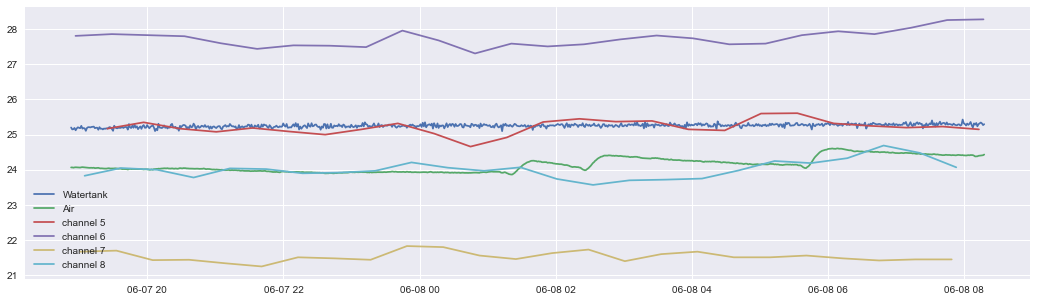

In [24]:
# Compare watertank to uncorrected channels
watertank_EGRT = 1689
watertank = "69"

plt.figure(figsize=(18,5))
position_watertank=15
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["5","6","7","8"]:
    inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank_EGRT].index
    val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank_EGRT].values
    plt.plot(inde,val, label=f"channel {c}")

plt.legend()

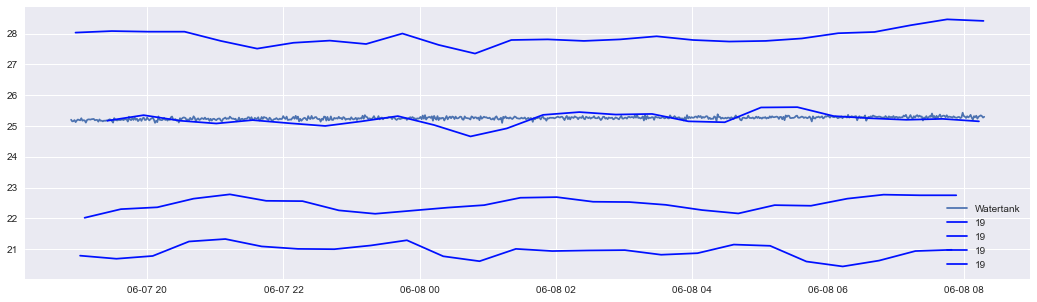

In [26]:
# Compare watertank to uncorrected channels - other watertank position 
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
col=get_cmap(7)

watertank_EGRT = 19 #unter 20 sind die Temp relativ konstant

#col=["black","green","blue","yellow"]

plt.figure(figsize=(18,5))
#position_watertank=15
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["5","6","7","8"]:
    for watertank_EGRT in [watertank_EGRT]:
        val=int(data_2021[c].columns[-1]) - watertank_EGRT
        watertank_EGRT_back=val
        inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank_EGRT_back].index
        val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank_EGRT_back].values

        #plt.plot(inde,val, label=f"channel {c}", color=col[int(c)-5]) # color channels
        plt.plot(inde,val, label=f"{watertank_EGRT}", color=col(int(watertank_EGRT)-15)) # color watertank_EGRT


plt.legend()
#Wassertank am 07.06. aufgefüllt, mit kälteren Wasser

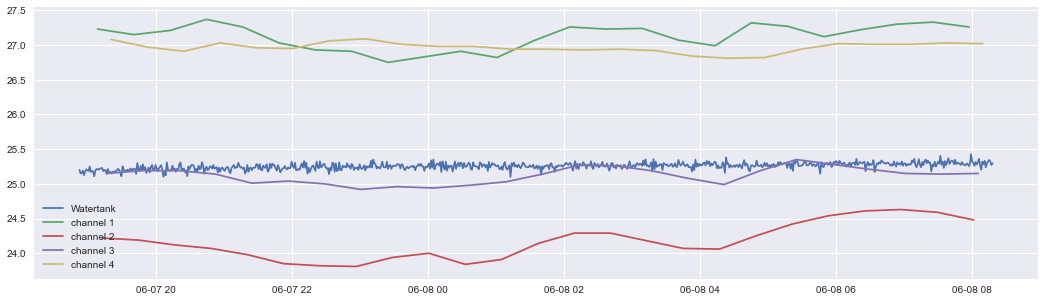

In [27]:
# Other channels
watertank = 69

plt.figure(figsize=(18,5))
position_watertank=15
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]:
    inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].index
    val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].values
    plt.plot(inde,val, label=f"channel {c}")
plt.legend()

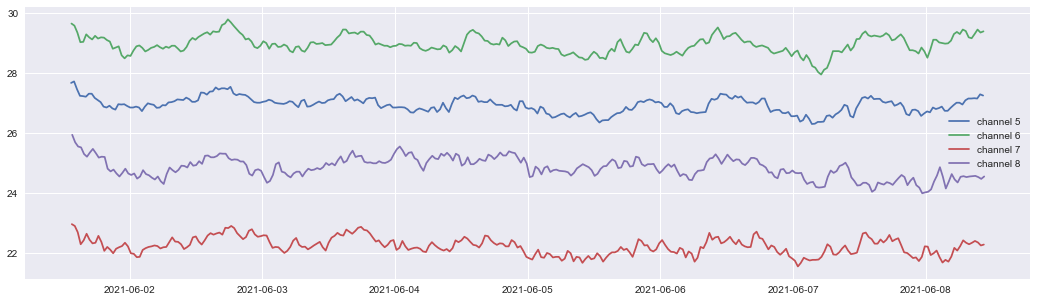

In [28]:
# Plot some data
plt.figure(figsize=(18,5))
length=10
#plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["5","6","7","8"]:
    inde=data_2021[c][:][length].index
    val=data_2021[c][:][length].values
    plt.plot(inde,val, label=f"channel {c}")

plt.legend()

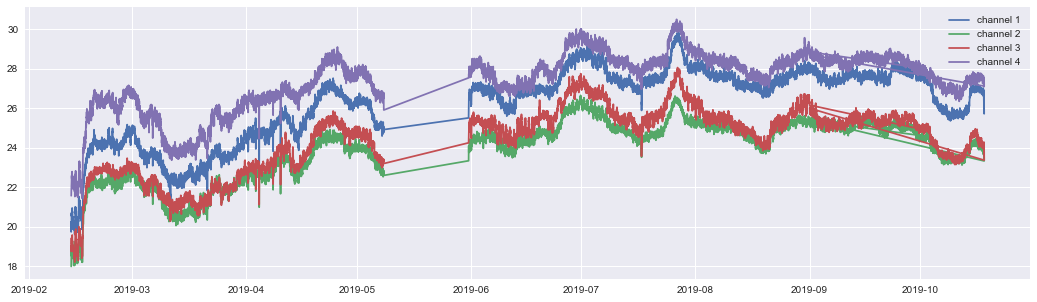

In [29]:
#plot data 2019
plt.figure(figsize=(18,5))
length=69
#plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]:
    inde=data_2019[c][:][length].index
    val=data_2019[c][:][length].values
    plt.plot(inde,val, label=f"channel {c}")

plt.legend()

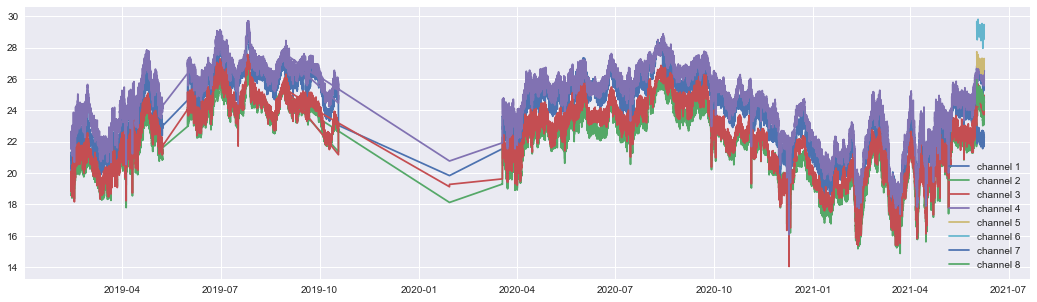

In [30]:
# Plot all data, very close to controller --> should all have same temp
plt.figure(figsize=(18,5))
length=10
#plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4","5","6","7","8"]:
    inde=data_all[c][length].index
    val=data_all[c][length].values
    plt.plot(inde,val, label=f"channel {c}")

plt.legend()

In [26]:
#

In [27]:
# # diff steigt mit länge des Kabels
# diff=np.abs(corrected_val["7"] - corrected_val["8"])
# diff_clean=np.delete(diff,np.where(diff > 6)) #remove outliers
# leng=len(diff_clean)
# x=np.arange(0,leng)

# plt.plot(x,diff_clean,label="diffs")
# a,b=np.polyfit(x,diff_clean,deg=1)

# plt.plot(x,b+a*x,label="linear fit")
# plt.legend()
# print(f"{a},    {b}")